<a href="https://colab.research.google.com/github/iamstarstuff/MScDataScienceThesis/blob/main/ML%20Models%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex
!pip install sklearn-genetic-opt[all]

zsh:1: no matches found: sklearn-genetic-opt[all]


In [1]:
import sklearnex
sklearnex.patch_sklearn()

# Getting the GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import tensorflow as tf
# Making sure the GPU is connected and will be used
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

gpus

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


zsh:1: command not found: nvidia-smi


2023-07-22 00:16:02.132810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]

In [64]:
# ALL IMPORTS
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
# Choose one of the ways to import data below.

# My local path
df = pd.read_csv('/Users/pratik/Github/MScDataScienceThesis/Skyserver_SQL5_24_2023 12_41_33 PM.csv')

# Global Path
# df = pd.read_csv("https://raw.githubusercontent.com/iamstarstuff/MScDataScienceThesis/main/Skyserver_SQL5_24_2023%2012_41_33%20PM.csv")

In [5]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237660e+18,213.992460,-2.453992,17.92948,18.19919,18.66623,19.01955,19.31679,2379,301,3,32,4.543040e+18,STAR,0.000076,4035,55383,112
1,1.237660e+18,214.058474,-2.597317,18.79543,17.72650,17.31048,17.14916,17.10742,2379,301,3,32,1.031330e+18,STAR,0.000092,916,52378,30
2,1.237660e+18,214.551367,-2.504556,19.32994,18.36031,18.04727,17.91241,17.85185,2379,301,3,36,4.539760e+18,STAR,0.000496,4032,55333,463
3,1.237660e+18,215.094035,-2.431390,19.58494,19.71145,19.29750,19.19037,19.28850,2379,301,3,39,1.032490e+18,QSO,1.340945,917,52400,160
4,1.237660e+18,215.137407,-2.539874,19.12029,18.20783,17.91957,17.80769,17.77281,2379,301,3,40,1.032490e+18,STAR,-0.000352,917,52400,142


In [6]:
df.shape

(500000, 18)

In [ ]:
class_mapping = {class_label: idx for idx, class_label in enumerate(df['class'].unique())}
df['Encoded_Class'] = df['class'].map(class_mapping)

In [ ]:
highcorr = df[['u','g','r','i','z','redshift','Encoded_Class']].corr()

<Axes: >

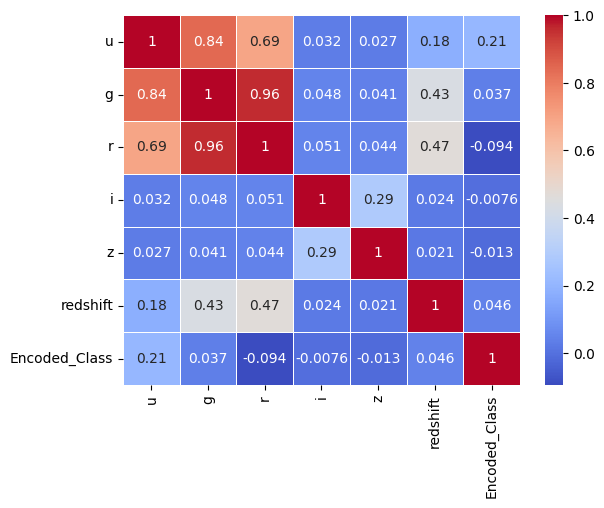

In [ ]:
sns.heatmap(highcorr, annot=True, cmap='coolwarm',lw=0.5)

In [24]:
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

In [25]:
X

,u,g,r,i,z,redshift
0,17.92948,18.19919,18.66623,19.01955,19.31679,0.000076
1,18.79543,17.72650,17.31048,17.14916,17.10742,0.000092
2,19.32994,18.36031,18.04727,17.91241,17.85185,0.000496
3,19.58494,19.71145,19.29750,19.19037,19.28850,1.340945
4,19.12029,18.20783,17.91957,17.80769,17.77281,-0.000352
...,...,...,...,...,...,...
499995,17.78246,16.86913,16.55873,16.43988,16.41700,-0.000542
499996,19.04626,18.06749,17.74344,17.63477,17.60972,0.000202
499997,19.58920,19.34045,19.15837,19.22703,18.96689,0.915697
499998,18.17178,17.14406,16.76121,16.61548,16.56664,-0.000357


In [26]:
# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [27]:
# Setting seeds for Reproducibility

import random
import numpy as np

random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [28]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6,random_state=random_seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=random_seed)

In [29]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(300000, 6)
(300000,)
(100000, 6)
(100000,)
(100000, 6)
(100000,)


(None, None)

In [61]:
y_train.value_counts()

class
GALAXY    151319
STAR      115894
QSO        32787
Name: count, dtype: int64

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train, )

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.98366


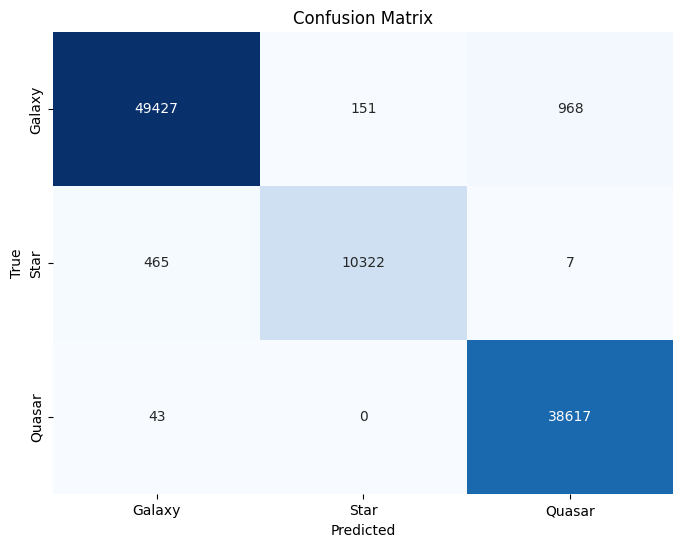

In [ ]:
y_pred = clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Galaxy', 'Star', 'Quasar'],
            yticklabels=['Galaxy', 'Star', 'Quasar'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': Continuous(1e-5, 1e10),  # Continuous range from 1e-5 to 1e10
    'gamma': Continuous(1e-15, 1e3),  # Continuous range from 1e-15 to 1e3
    'kernel': Categorical(['linear', 'rbf', 'poly'])
}

# Create the SVM classifier
svc = SVC()


# Create the genetic algorithm search object
ga_search = GASearchCV(
    estimator=svc,
    cv=cv,
    scoring='accuracy',
    population_size=5,
    generations=5,
    tournament_size=3,
    elitism=True,
    crossover_probability=0.5,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria='max',
    algorithm='eaMuPlusLambda',
    n_jobs=-1,
    verbose=True,
    keep_top_k=3 
)

# Perform the hyperparameter tuning
ga_search.fit(X_train, y_train)

In [ ]:
# Get the best hyperparameters and accuracy score
best_params = ga_search.best_params_
best_score = ga_search.best_score_

# Train the classifier with the best hyperparameters
best_clf = SVC(C=best_params['C'], gamma=best_params['gamma'])
best_clf.fit(X_train, y_train)

# Predict the labels for the test set using the best classifier
y_pred = best_clf.predict(X_test)

# Calculate the accuracy of the best classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_score)
print("Test Accuracy:", accuracy)

# Random Forest

In [33]:
rfc = RandomForestClassifier(random_state=random_seed)

## Baseline
Performance of classifier using the default hyperparameter values

In [35]:
rfc.fit(X_train,y_train)

y_test_pred = rfc.predict(X_test)
y_valid_pred = rfc.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.99087
Validation set Accuracy: 0.99103


In [63]:

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50399
         QSO       0.98      0.95      0.96     10798
        STAR       0.99      1.00      0.99     38803

    accuracy                           0.99    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000



**👆🏻Signs of overfitting**

## Genetic optimisation

In [36]:
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform',
                                                     random_state=random_seed),
              'n_estimators': Integer(100, 300,random_state=random_seed)}

# Write about why we use StratifiedKFold
# https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

evolved_estimator = GASearchCV(estimator=rfc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=5,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [37]:
# TAKES ABOUT 15-20 MINUTES TO RUN
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.947144	0.0488439  	0.974233   	0.82207    
1  	12    	0.972184	0.00182328 	0.974233   	0.96921    
2  	9     	0.97342 	0.0015451  	0.974233   	0.969343   
3  	13    	0.974304	0.000155524	0.974733   	0.974233   
4  	13    	0.974365	0.00015585 	0.974733   	0.974233   
5  	14    	0.975109	0.00186352 	0.980673   	0.974233   


GASearchCV(crossover_probability=0.5,
           cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
           estimator=RandomForestClassifier(min_weight_fraction_leaf=0.014454547118247537,
                                            n_estimators=125, random_state=42),
           generations=5, keep_top_k=3, mutation_probability=0.1, n_jobs=-1,
           param_grid={'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x17916bb90>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x1791fa4d0>},
           population_size=10, return_train_score=True, scoring='accuracy')

In [38]:
y_test_predict_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_test_predict_ga)

0.97404

In [39]:
y_valid_pred_ga = evolved_estimator.predict(X_valid)
accuracy_score(y_valid, y_valid_pred_ga)

0.9741

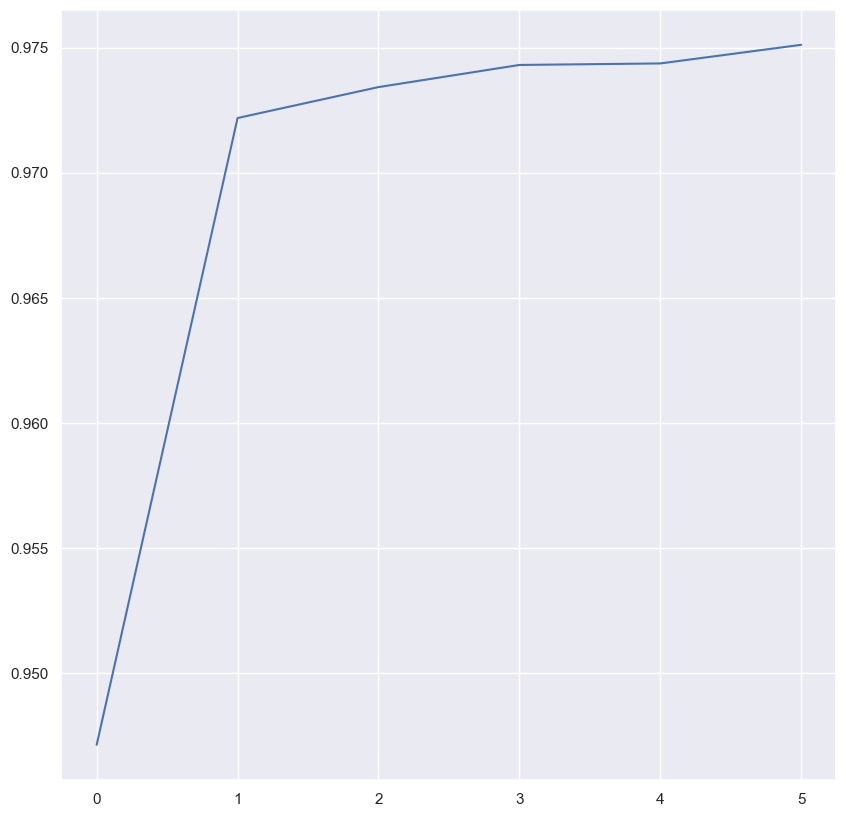

In [47]:
# plot_fitness_evolution(evolved_estimator)
plt.plot([0,1,2,3,4,5],[0.947144,0.972184,0.97342,0.974304,0.974365,0.975109])
plt.show()

In [48]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(evolved_estimator.hof)

,0,1,2
min_weight_fraction_leaf,0.014455,0.014455,0.014455
n_estimators,125.000000,203.000000,255.000000


# Gradient Boosting Classifier

## Baseline

In [49]:
gbc = GradientBoostingClassifier(random_state=random_seed)

In [50]:
# TAKES 5 MINUTES TO RUN
gbc.fit(X_train, y_train)

y_test_pred = gbc.predict(X_test)
y_valid_pred = gbc.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.98753
Validation set Accuracy: 0.98769


## Genetic Optimisation

In [51]:
gbc = GradientBoostingClassifier(random_state=random_seed)

param_grid = {
    'learning_rate': Categorical([0.0001, 0.001, 0.01, 0.1],random_state=random_seed),
    'n_estimators': Integer(50, 200, distribution='uniform',random_state=random_seed)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

evolved_estimator = GASearchCV(estimator=gbc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=5,
                               generations=5,
                               tournament_size=2,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [52]:
# TAKES 150 MINUTES TO RUN
gbc_evolved_estimator = evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.849961	0.178561   	0.98796    	0.504397   
1  	5     	0.966912	0.0404792  	0.98796    	0.885983   
2  	6     	0.987241	0.00111534 	0.98796    	0.98503    
3  	4     	0.987778	0.000187517	0.98805    	0.987627   
4  	5     	0.98776 	0.000163299	0.98796    	0.987627   
5  	7     	0.987893	0.000133333	0.98796    	0.987627   


In [53]:

y_test_pred_gbc_ga = evolved_estimator.predict(X_test)
y_valid_pred_gbc_ga = evolved_estimator.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_gbc_ga)
validation_accuracy = accuracy_score(y_valid, y_valid_pred_gbc_ga)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.98782
Validation set Accuracy: 0.98818


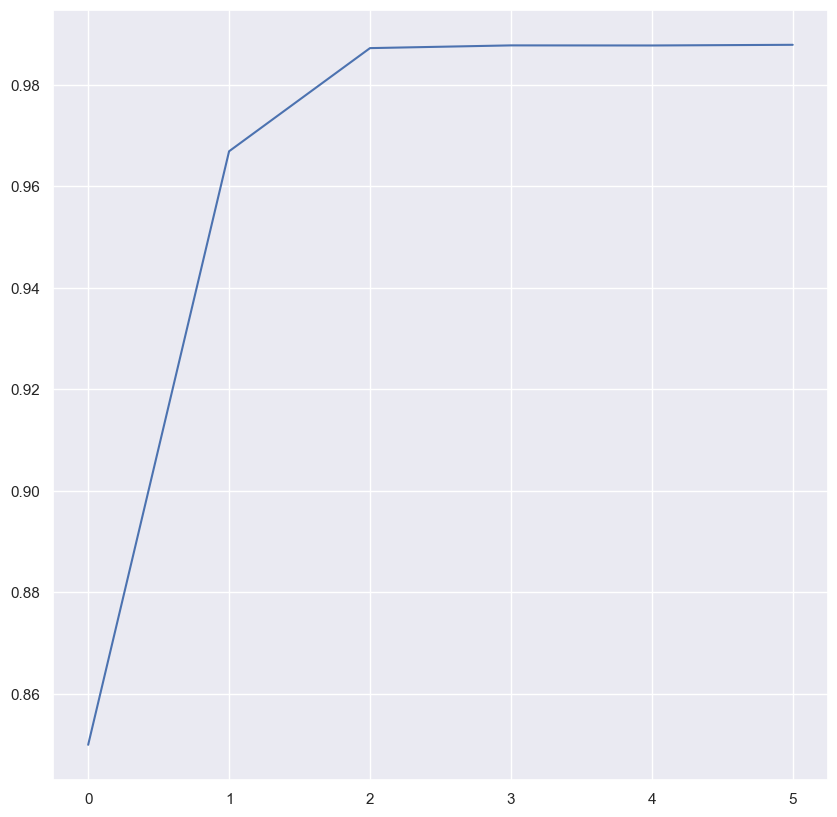

In [56]:
plt.plot([0,1,2,3,4,5],[0.849961,0.966912,0.987241,0.987778,0.98776,0.987893])

In [57]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(gbc_evolved_estimator.hof)

,0,1,2
learning_rate,0.1,0.1,0.1
n_estimators,179.0,166.0,155.0
